In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_skip'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

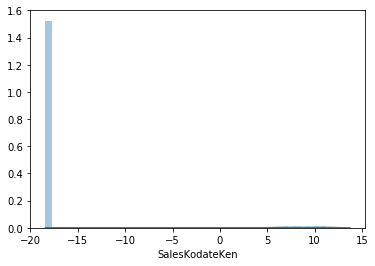

In [3]:
sns.distplot(np.log(df_train_Y['SalesKodateKen'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['SalesKodateKen']:
    df_train_Y['SalesKodateKen_log'] = df_train_Y['SalesKodateKen'].apply(log)
    df_val_Y['SalesKodateKen_log'] = df_val_Y['SalesKodateKen'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['SalesKodateKen_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['SalesKodateKen_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### xgboost モデルの作成

In [6]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=100, 
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:16.9577	eval-rmse:16.9841
[1]	train-rmse:15.3321	eval-rmse:15.3737
[2]	train-rmse:13.8747	eval-rmse:13.9308
[3]	train-rmse:12.5685	eval-rmse:12.6435
[4]	train-rmse:11.4012	eval-rmse:11.4953
[5]	train-rmse:10.3557	eval-rmse:10.4682
[6]	train-rmse:9.41986	eval-rmse:9.55028
[7]	train-rmse:8.58486	eval-rmse:8.73618
[8]	train-rmse:7.8425	eval-rmse:8.0196
[9]	train-rmse:7.18001	eval-rmse:7.38687
[10]	train-rmse:6.59242	eval-rmse:6.82664
[11]	train-rmse:6.07167	eval-rmse:6.33869
[12]	train-rmse:5.60912	eval-rmse:5.91138
[13]	train-rmse:5.20249	eval-rmse:5.5376
[14]	train-rmse:4.84382	eval-rmse:5.21567
[15]	train-rmse:4.52437	eval-rmse:4.94051
[16]	train-rmse:4.24961	eval-rmse:4.70495
[17]	train-rmse:4.00964	eval-rmse:4.50396
[18]	train-rmse:3.8013	eval-rmse:4.337
[19]	train-rmse:3.61971	eval-rmse:4.19411
[20]	train-rmse:3.46009	eval-rmse:4.07714
[21]	train-rmse:3.32047	eval-rmse:3.9816
[22]	train-rmse:3.19987	eval-rmse:3.90239
[23]	train-rmse:3.09547	eval-rmse:3.83031
[24]	trai

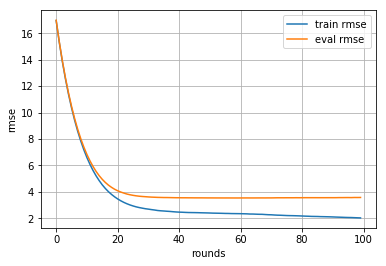

In [7]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

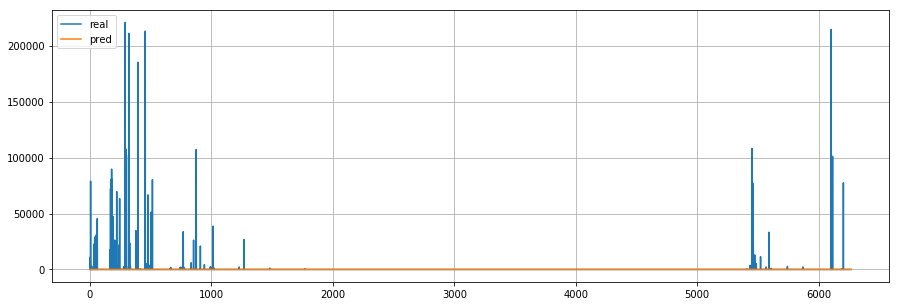

In [8]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['SalesKodateKen'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

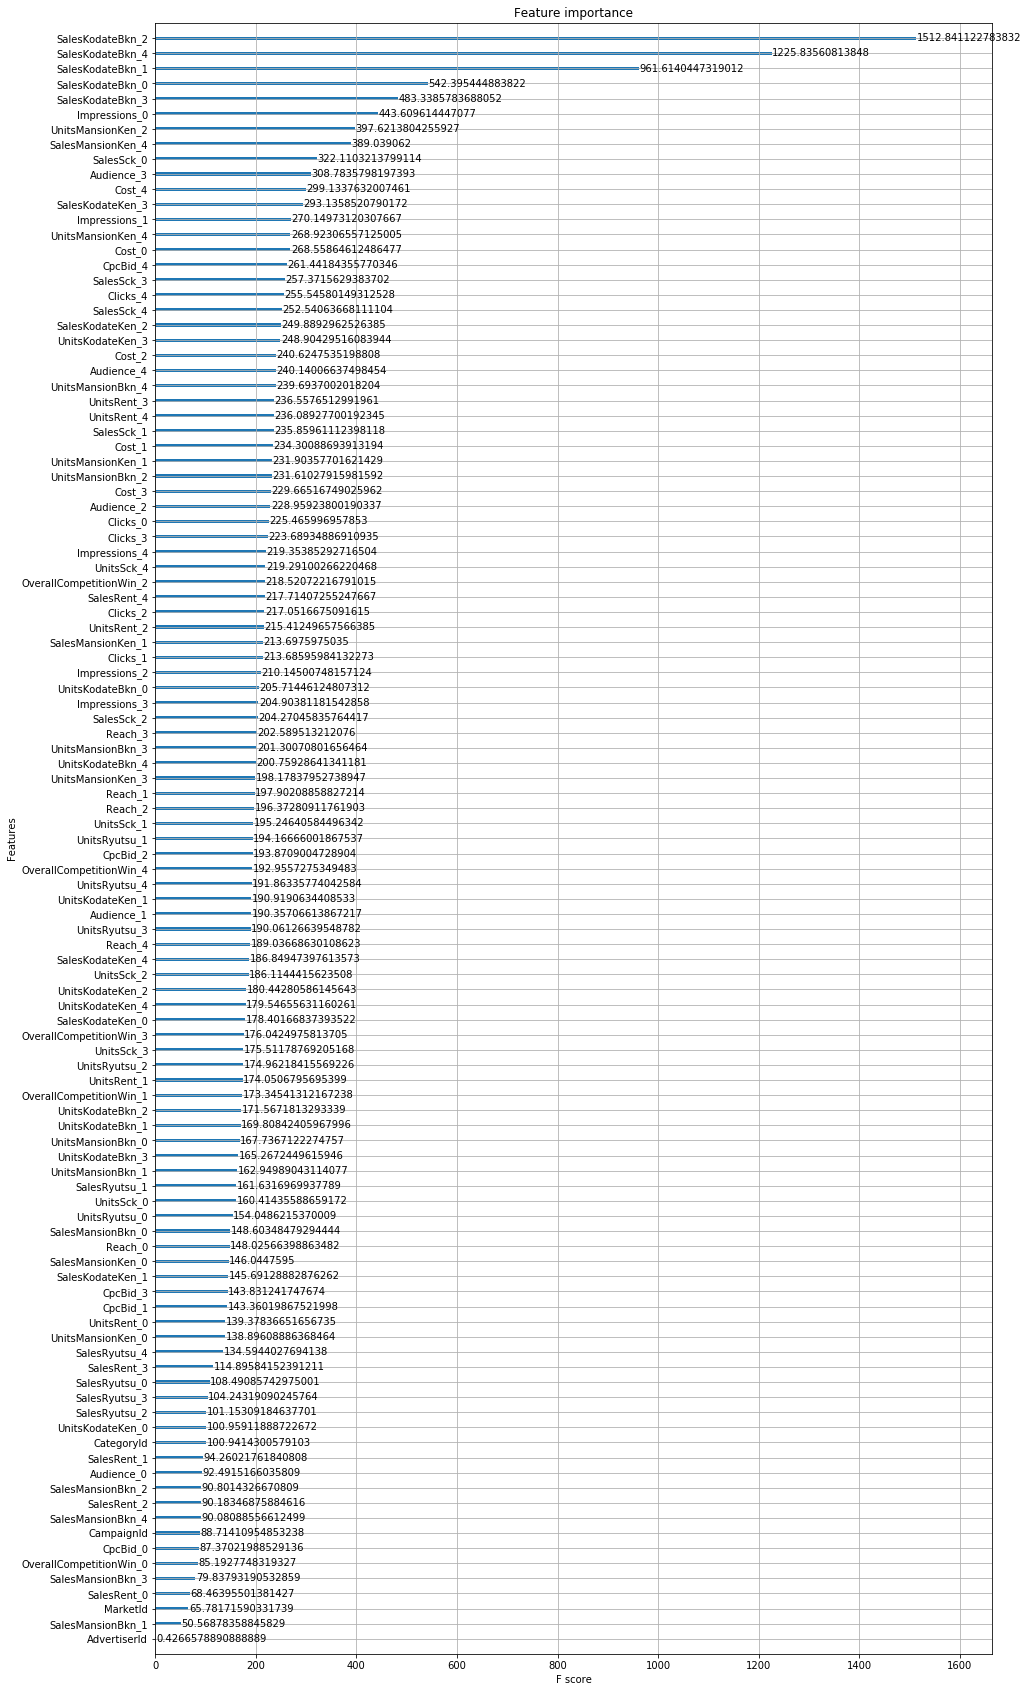

In [9]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [10]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['SalesKodateBkn_2',
 'SalesKodateBkn_4',
 'SalesKodateBkn_1',
 'SalesKodateBkn_0',
 'SalesKodateBkn_3',
 'Impressions_0',
 'UnitsMansionKen_2',
 'SalesMansionKen_4',
 'SalesSck_0',
 'Audience_3',
 'Cost_4',
 'SalesKodateKen_3',
 'Impressions_1',
 'UnitsMansionKen_4',
 'Cost_0',
 'CpcBid_4',
 'SalesSck_3',
 'Clicks_4',
 'SalesSck_4',
 'SalesKodateKen_2',
 'UnitsKodateKen_3',
 'Cost_2',
 'Audience_4',
 'UnitsMansionBkn_4',
 'UnitsRent_3',
 'UnitsRent_4',
 'SalesSck_1',
 'Cost_1',
 'UnitsMansionKen_1',
 'UnitsMansionBkn_2',
 'Cost_3',
 'Audience_2',
 'Clicks_0',
 'Clicks_3',
 'Impressions_4',
 'UnitsSck_4',
 'OverallCompetitionWin_2',
 'SalesRent_4',
 'Clicks_2',
 'UnitsRent_2',
 'SalesMansionKen_1',
 'Clicks_1',
 'Impressions_2',
 'UnitsKodateBkn_0',
 'Impressions_3',
 'SalesSck_2',
 'Reach_3',
 'UnitsMansionBkn_3',
 'UnitsKodateBkn_4',
 'UnitsMansionKen_3',
 'Reach_1',
 'Reach_2',
 'UnitsSck_1',
 'UnitsRyutsu_1',
 'CpcBid_2',
 'OverallCompetitionWin_4',
 'UnitsRyutsu_4',
 'UnitsKodateK